# Winnow: *de novo* sequencing confidence calibration and FDR control tutorial

<a target="_blank" href="https://colab.research.google.com/github/instadeepai/winnow/blob/main/notebooks/getting_started_with_winnow.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook demonstrates how to use the `winnow` package for confidence calibration and false discovery rate (FDR) control in *de novo* sequencing (DNS) workflows.

In the rest of the notebook, you'll:
- Set up the environment and download example datasets.
- Load and filter spectra and beam predictions; inspect key metadata.
- Configure Winnow features (Mass Error, Prosit spectral/iRT, Chimeric, Beam) and train a calibrator on the HeLa Single Shot dataset.
- Evaluate calibration with precision–recall curves, score transformation, confidence distributions, and calibration curves.
- Control FDR via two approaches: database-grounded and label-free non-parametric; add per-PSM FDR/PEP/q-values and plot PSM FDR vs. confidence.
- Apply the trained calibrator and label-free FDR to raw, unlabelled HeLa Single Shot data and filter results by a 5% FDR cutoff.
- Extend Winnow: implement a custom feature, save/reload a calibrator, and run the workflow via the CLI.
- Use a minimal (Prosit-free) feature set when Prosit isn't available.
- Load a pretrained general calibrator and reproduce results on another dataset (Immunopeptidomics-2).
- Review tips, troubleshooting notes, and additional resources.

<img src="../assets/winnow-pipeline.png" alt="winnow pipeline" width="600">

## Overview

`winnow` implements a calibrate‑estimate framework for FDR control in *de novo* peptide sequencing. The flow:

1. **Confidence calibration**: Learn a mapping from raw model confidence and auxiliary features to an improved, better‑calibrated probability of correctness.
2. **FDR estimation**: Estimate/control FDR either with labels (database‑grounded) or without labels via a non-parametric procedure.

## Links

- **Preprint**: [De novo peptide sequencing rescoring and FDR estimation with Winnow](https://arxiv.org/abs/2509.24952)
- **Code**: [GitHub](https://github.com/instadeepai/winnow)

## 1. Setup and imports

First [install `uv`](https://docs.astral.sh/uv/getting-started/installation/). Then import all the necessary packages and set up logging.

In [4]:
# Install the dependencies for running this notebook
!uv pip install winnow-fdr huggingface-hub seaborn tqdm ipykernel

Using Python 3.13.6 environment at: /home/j-vangoey/code/winnow/.venv
Audited 5 packages in 11ms


In [5]:
import logging
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from huggingface_hub import list_repo_files, snapshot_download

from winnow.calibration.calibration_features import (
    BeamFeatures,
    CalibrationFeatures,
    ChimericFeatures,
    MassErrorFeature,
    PrositFeatures,
    RetentionTimeFeature,
)
from winnow.calibration.calibrator import ProbabilityCalibrator
from winnow.constants import RESIDUE_MASSES
from winnow.datasets.calibration_dataset import CalibrationDataset
from winnow.datasets.data_loaders import InstaNovoDatasetLoader
from winnow.fdr.database_grounded import DatabaseGroundedFDRControl
from winnow.fdr.nonparametric import NonParametricFDRControl

# Suppress UserWarnings from winnow about FDR control extrapolation
warnings.filterwarnings("ignore", module="winnow")

sns.set_theme(style="whitegrid", context="notebook")

/home/j-vangoey/code/winnow/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[09/30/25 17:57:59] INFO     Enabling RDKit 2024.09.6 jupyter extensions                                                                                         ]8;id=667614;file:///home/j-vangoey/code/winnow/.venv/lib/python3.13/site-packages/rdkit/__init__.py\__init__.py]8;;\:]8;id=569960;file:///home/j-vangoey/code/winnow/.venv/lib/python3.13/site-packages/rdkit/__init__.py#22\22]8;;\

In [6]:
# -- Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

## 2. Data download

Let's download a HeLa single cell dataset and its corresponding InstaNovo predictions from [Hugging Face](https://huggingface.co/datasets/JemmaDaniel/winnow-ms-datasets).

In [7]:
repo_id = "InstaDeepAI/winnow-ms-datasets"
save_dir = "winnow-ms-datasets"

files = list_repo_files(repo_id=repo_id, repo_type="dataset")
print([f for f in files])

['.gitattributes', 'README.md', 'celegans_labelled.parquet', 'celegans_labelled_beams.csv', 'celegans_raw.parquet', 'celegans_raw_beams.csv', 'general_test.parquet', 'general_test_beams.csv', 'general_train.parquet', 'general_train_beams.csv', 'general_val.parquet', 'general_val_beams.csv', 'helaqc_labelled.parquet', 'helaqc_labelled_beams.csv', 'helaqc_raw_less_train.parquet', 'helaqc_raw_less_train_beams.csv', 'immuno2_labelled.parquet', 'immuno2_labelled_beams.csv', 'immuno2_raw.parquet', 'immuno2_raw_beams.csv']


In [8]:
# -- Download the helaqc dataset
snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    allow_patterns=["helaqc*.parquet", "helaqc*.csv"],
    local_dir=save_dir,
)

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 38043.57it/s]


'/home/j-vangoey/code/winnow/examples/winnow-ms-datasets'

## 3. Data loading and preparation

In a typical workflow, you'll have:
- **Spectrum data**: MS/MS spectra with metadata (charge, m/z, retention time)
- **Beam predictions**: Peptide sequence predictions from your *de novo* model
- **Annotations (Optional)**: Ground truth labels (for training/evaluation)

If you do not have beam predictions (i.e., traditional search enginers or DNS models without beam search), you can submit a predictions list with just a single prediction per spectrum and its associated log-probabilities.

### Available data loaders

Winnow currently provides these built-in DatasetLoaders:

1. **`InstaNovoDatasetLoader`**: For InstaNovo CSV predictions and Parquet or IPC spectrum data
2. **`MZTabDatasetLoader`**: For Casanovo or search engine MZTab files and Parquet or IPC spectrum data
3. **`WinnowDatasetLoader`**: For previously saved CalibrationDataset instances
4. **`PointNovoDatasetLoader`**: For PointNovo predictions (in development)

In [9]:
# -- Load data
logger.info("Loading dataset.")
dataset = InstaNovoDatasetLoader().load(
    data_path="winnow-ms-datasets/helaqc_labelled.parquet",
    predictions_path="winnow-ms-datasets/helaqc_labelled_beams.csv",
)

logger.info("Filtering dataset.")
filtered_dataset = (
    dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
    .filter_entries(
        metadata_predicate=lambda row: row["precursor_charge"] > 6
    )  # Prosit-specific filtering, see https://github.com/Nesvilab/FragPipe/issues/1775
    .filter_entries(
        metadata_predicate=lambda row: len(row["prediction"]) > 30
    )  # Prosit-specific filtering
    .filter_entries(
        predictions_predicate=lambda row: len(row[1].sequence) > 30
    )  # Prosit-specific filtering
)

Loading dataset.


[09/30/25 17:58:03] INFO     Loading dataset.                                                                                                                   ]8;id=998812;file:///tmp/ipykernel_19645/2712553122.py\2712553122.py]8;;\:]8;id=160358;file:///tmp/ipykernel_19645/2712553122.py#2\2]8;;\

Applying dataset filters...


Filtering dataset.


[09/30/25 17:58:10] INFO     Filtering dataset.                                                                                                                 ]8;id=930007;file:///tmp/ipykernel_19645/2712553122.py\2712553122.py]8;;\:]8;id=536040;file:///tmp/ipykernel_19645/2712553122.py#8\8]8;;\

In [10]:
# -- Split data into train and test sets
train_dataset = filtered_dataset.filter_entries(
    metadata_predicate=lambda row: row["split"] == "test"
)
test_dataset = filtered_dataset.filter_entries(
    metadata_predicate=lambda row: row["split"] == "train"
)

print("Number of spectra in train set:", len(train_dataset))
print("Number of spectra in test set:", len(test_dataset))

Number of spectra in train set: 11072
Number of spectra in test set: 2768


In [11]:
train_dataset.metadata.head()

,spectrum_id,sequence_untokenised,prediction_untokenised,prediction,confidence,token_log_probs,sequence,precursor_charge,precursor_mass,retention_time,mz_array,intensity_array,split,valid_peptide,valid_prediction,num_matches,correct
0,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,MVMIQDGPIPTGADKPIR,AIPAVQENNIDEEIRPK,"[A, I, P, A, V, Q, E, N, N, I, D, E, E, I, R, ...",0.004802,"[-0.02448706328868866, -2.863399028778076, -0....","[M, V, M, I, Q, D, G, P, I, P, T, G, A, D, K, ...",3,1939.01786,40.8172,"[120.08053588867188, 129.0656280517578, 129.10...","[34712.6328125, 3535.3974609375, 65278.5, 1089...",train,True,True,0,False
1,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,RQNGDDPIITYRFPPK,RQNGDDPIITYRFPPK,"[R, Q, N, G, D, D, P, I, I, T, Y, R, F, P, P, K]",0.402060,"[-0.013354731723666191, -0.006628194823861122,...","[R, Q, N, G, D, D, P, I, I, T, Y, R, F, P, P, K]",3,1917.00235,40.8183,"[120.08051300048828, 121.08369445800781, 129.1...","[41311.62109375, 2239.29443359375, 19945.63476...",train,True,True,16,True
2,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,SQVEPADYKADEDPAIFQSVK,SQVEPADYKADEDPAIFQSVK,"[S, Q, V, E, P, A, D, Y, K, A, D, E, D, P, A, ...",0.820328,"[-0.005710715427994728, -0.013795150443911552,...","[S, Q, V, E, P, A, D, Y, K, A, D, E, D, P, A, ...",3,2337.11899,40.8252,"[120.08015441894531, 129.0649871826172, 129.10...","[5206.16064453125, 1753.3909912109375, 13565.5...",train,True,True,21,True
3,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,RSTMVGTPYWMAPEVVTRK,RSTMVGTPYWMAPEVVTRK,"[R, S, T, M, V, G, T, P, Y, W, M, A, P, E, V, ...",0.896467,"[-2.9801878554280847e-05, -0.10199732333421707...","[R, S, T, M, V, G, T, P, Y, W, M, A, P, E, V, ...",3,2209.12937,40.8333,"[120.08053588867188, 122.73236846923828, 122.7...","[3890.96728515625, 1702.5179443359375, 1581.67...",train,True,True,19,True
4,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,IRYESGDHVAVYPANDSAIVNQIGK,IRYESGDHVAVYPANDSAIVNQIGK,"[I, R, Y, E, S, G, D, H, V, A, V, Y, P, A, N, ...",0.673091,"[-0.006981028709560633, -0.0003036991693079471...","[I, R, Y, E, S, G, D, H, V, A, V, Y, P, A, N, ...",3,2716.36155,40.8356,"[127.98652648925781, 129.10203552246094, 136.0...","[1876.14794921875, 2905.578125, 2134.045166015...",train,True,True,25,True


### Metadata columns

Each row corresponds to an MS2 spectrum with metadata and arrays:
- `spectrum_id` (string): unique spectrum identifier, constructed by concatenating experiment name with scan number
- `sequence_untokenised` (string): ground truth peptide sequence from database search, for labelled data only, as a string
- `prediction_untokenised` (string): model-predicted peptide sequence as a string
- `prediction` (list(string)): model-predicted peptide sequence as a list of amino acids 
- `confidence` (float): model confidence for the top prediction, ranges between 0 and 1
- `token_log_probs` (list(float)): amino acid-level log-probabilities
- `sequence` (string): ground truth peptide sequence from database search, for labelled data only
- `precursor_charge` (int): charge of the precursor (from MS1)
- `precursor_mass` (float): mass of the precursor ion (from MS1)
- `retention_time` (float): retention time (seconds)
- `mz_array` (list[float]): mass-to-charge values of the MS2 spectrum
- `intensity_array` (list[float]): intensity values of the MS2 spectrum
- `split` (string): train, test or validation split identity for the MS2 spectrum (not required by Winnow)
- `valid_peptide` (boolean): whether the entry in `sequence` is of type list
- `valid_prediction` (boolean): whether the entry in `prediction` is of type list
- `num_matches` (integer): number of token-level matches between the sequence and prediction, if labelled
- `correct` (boolean): whether the predicted peptide sequence is correct (i.e., do all tokens match)


In [12]:
# Print the first 3 beam results for the first spectrum
train_dataset.predictions[0][0:3]

[ScoredSequence(sequence=['A', 'I', 'P', 'A', 'V', 'Q', 'E', 'N', 'N', 'I', 'D', 'E', 'E', 'I', 'R', 'P', 'K'], mass_error=None, sequence_log_probability=-5.338695049285889, token_log_probabilities=None),
 ScoredSequence(sequence=['A', 'I', 'P', 'A', 'V', 'Q', 'E', 'N', 'N', 'I', 'D', 'E', 'E', 'I', 'R', 'P', 'K'], mass_error=None, sequence_log_probability=-6.004067897796631, token_log_probabilities=None),
 ScoredSequence(sequence=['V', 'E', 'M', 'I', 'Q', 'D', 'G', 'P', 'I', 'P', 'T', 'G', 'A', 'D', 'K', 'P', 'I', 'R'], mass_error=None, sequence_log_probability=-17.42746925354004, token_log_probabilities=None)]

### Creating a custom dataset loader

For unsupported formats, implement the `DatasetLoader` interface with a single `load` method returning a `CalibrationDataset`. 

**Required inputs:**
- `spectrum_id`: Unique identifier for each spectrum
- `prediction`: Predicted sequence as a string of amino acids
- `confidence`: PSM score
- `precursor_charge`, `precursor_mass`, `retention_time`: spectral metadata
- `mz_array`, `intensity_array`: Spectrum data as lists

**Note**: PTM modifications should also be mapped to UNIMOD format, similar to the `RESIDUE_REMAPPING` dictionaries in `winnow/constants.py`.

### Integration with CLI

Once you've created a custom loader, you can integrate it with Winnow's CLI by:

1. Adding your loader to `winnow/datasets/data_loaders.py`
2. Creating a corresponding config class for your data source
3. Adding the new data source to the CLI's `DataSource` enum
4. Updating the `load_dataset` function in `winnow/scripts/main.py`

This allows you to use your custom loader with commands like:
```bash
winnow train --data-source my_custom_format --dataset-config-path my_config.yaml
```

## 4. Feature engineering deep dive

Below we describe the built‑in features that Winnow can use as complementary signals during the calibration step. Which features are informative depends on the dataset, instrument, acquisition settings and the upstream DNS model. Use the descriptions below to decide what to enable, and validate with ablations on your data.

### Mass error
What it captures: Consistency between the observed precursor mass and the theoretical mass of the predicted peptide (accounting for H2O and a proton).
- Inputs used: `prediction`, `precursor_mass`, plus `RESIDUE_MASSES` for theoretical mass.
- Metadata columns created: `Mass Error`.

### Prosit features
What it captures: How well Prosit‑predicted fragment ions explain the experimental spectrum.
- Implemented as: fraction of matched ions and average matched intensity within an m/z tolerance.
- Inputs used: `prediction`, `mz_array`, `intensity_array`, `precursor_charge`.
- Metadata columns created: `prosit_mz`, `prosit_intensity`, `ion_matches`, `ion_match_intensity`.

### Prosit iRT features
What it captures: Agreement between Prosit iRT (sequence‑based) and observed retention time, via a small RT calibration model trained on high‑confidence PSMs.
- Inputs used: `prediction`, `retention_time`.
- Metadata columns created: `iRT`, `predicted iRT`, `iRT error`.

### Chimeric features
What it captures: Whether runner‑up sequences also explain the spectrum (a proxy for chimericity).
- Implemented as: ion match rate/intensity for the second‑best sequence.
- Inputs used: `prediction` beams, `mz_array`, `intensity_array`, `precursor_charge`.
- Metadata columns created: `runner_up_prosit_mz`, `runner_up_prosit_intensity`, `chimeric_ion_matches`, `chimeric_match_intensity`.

### Beam features
What it captures: Properties of the decoding distribution (margin to runner‑ups, median margin, entropy, and a z‑score of the top beam relative to its peers).
- Inputs used: beam log‑probabilities from the upstream model.
- Metadata columns created: `margin`, `median_margin`, `entropy`, `z-score`.

### Supported modifications and sequence notation

Winnow expects tokenised peptide sequences where modifications are encoded inline using UNIMOD bracket notation. Examples:
- Tokenised format: `A, C[UNIMOD:4], M[UNIMOD:35], Y[UNIMOD:21]`
- Untokenised example (for display): `AC[UNIMOD:4]M[UNIMOD:35]Y[UNIMOD:21]`

Supported modification tokens (parsed via `RESIDUE_MASSES`):
- `C[UNIMOD:4]`: Carbamidomethylation (fixed, C)
- `M[UNIMOD:35]`: Oxidation (M)
- `N[UNIMOD:7]`, `Q[UNIMOD:7]`: Deamidation (N/Q)
- `S[UNIMOD:21]`, `T[UNIMOD:21]`, `Y[UNIMOD:21]`: Phosphorylation (S/T/Y)
- `[UNIMOD:1]`: Acetylation (e.g., N-term)
- `[UNIMOD:5]`: Carbamylation
- `[UNIMOD:385]`: Ammonia loss

Accepted legacy/alternate notations are auto‑remapped to UNIMOD tokens during loading (via `RESIDUE_REMAPPING`):
- `M(ox)`, `M(+15.99)` → `M[UNIMOD:35]`
- `S(p)`, `T(p)`, `Y(p)`, `S(+79.97)`, `T(+79.97)`, `Y(+79.97)` → `*[UNIMOD:21]`
- `Q(+0.98)`, `N(+0.98)`, `Q(+.98)`, `N(+.98)` → `*[UNIMOD:7]`
- `C(+57.02)` → `C[UNIMOD:4]`
- `(+42.01)` → `[UNIMOD:1]`; `(+43.01)` → `[UNIMOD:5]`; `(-17.03)` → `[UNIMOD:385]`

Notation and preprocessing details:
- Sequences are tokenised as comma‑separated tokens in the dataset (e.g., `preds_tokenised`), and Winnow normalises `L` to `I` on load.
- For Prosit‑based features (spectral and iRT): only peptides with supported modifications are queried. Rows with unsupported modifications are filtered. Carbamidomethylation on C (`C[UNIMOD:4]`) is treated as fixed; when querying Prosit, this is internally mapped to `C`.
- If many rows are filtered during Prosit feature computation, review your modification tokens and acquisition settings.

## 5. Calibration workflow

In [13]:
# -- Set up calibrator
logger.info("Initialising calibrator.")
SEED = 42
calibrator = ProbabilityCalibrator(SEED)

logger.info("Adding features to calibrator.")
MZ_TOLERANCE = 0.02
HIDDEN_DIM = 10
TRAIN_FRACTION = 0.1
calibrator.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
calibrator.add_feature(PrositFeatures(mz_tolerance=MZ_TOLERANCE))
calibrator.add_feature(
    RetentionTimeFeature(hidden_dim=HIDDEN_DIM, train_fraction=TRAIN_FRACTION)
)
calibrator.add_feature(ChimericFeatures(mz_tolerance=MZ_TOLERANCE))
calibrator.add_feature(BeamFeatures())

Initialising calibrator.


                    INFO     Initialising calibrator.                                                                                                           ]8;id=606625;file:///tmp/ipykernel_19645/3963011901.py\3963011901.py]8;;\:]8;id=197481;file:///tmp/ipykernel_19645/3963011901.py#2\2]8;;\

Adding features to calibrator.


                    INFO     Adding features to calibrator.                                                                                                     ]8;id=129378;file:///tmp/ipykernel_19645/3963011901.py\3963011901.py]8;;\:]8;id=898564;file:///tmp/ipykernel_19645/3963011901.py#6\6]8;;\

In [14]:
# -- Calibrate
logger.info("Calibrating scores.")
calibrator.fit(train_dataset)
calibrator.predict(test_dataset)

Calibrating scores.


[09/30/25 17:58:14] INFO     Calibrating scores.                                                                                                                ]8;id=400665;file:///tmp/ipykernel_19645/2759858474.py\2759858474.py]8;;\:]8;id=3516;file:///tmp/ipykernel_19645/2759858474.py#2\2]8;;\

Prosit_2019_irt:: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]
/home/j-vangoey/code/winnow/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Prosit_2020_intensity_HCD:: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


In [15]:
train_dataset.metadata.head()

,spectrum_id,sequence_untokenised,prediction_untokenised,prediction,confidence,token_log_probs,sequence,precursor_charge,precursor_mass,retention_time,...,predicted iRT,iRT error,runner_up_prosit_mz,runner_up_prosit_intensity,chimeric_ion_matches,chimeric_ion_match_intensity,margin,median_margin,entropy,z-score
0,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,MVMIQDGPIPTGADKPIR,AIPAVQENNIDEEIRPK,"[A, I, P, A, V, Q, E, N, N, I, D, E, E, I, R, ...",0.004802,"[-0.02448706328868866, -2.863399028778076, -0....","[M, V, M, I, Q, D, G, P, I, P, T, G, A, D, K, ...",3,1939.01786,40.8172,...,81.157393,23.600562,"[134.09375, 177.11280822753906, 185.1284484863...","[0.0002702334022615105, 0.0007334070396609604,...",0.259259,0.024787,0.002333,0.004802,0.000207,6.211981
1,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,RQNGDDPIITYRFPPK,RQNGDDPIITYRFPPK,"[R, Q, N, G, D, D, P, I, I, T, Y, R, F, P, P, K]",0.402060,"[-0.013354731723666191, -0.006628194823861122,...","[R, Q, N, G, D, D, P, I, I, T, Y, R, F, P, P, K]",3,1917.00235,40.8183,...,81.159535,19.913052,"[147.11280822753906, 244.1655731201172, 341.21...","[0.079371377825737, 0.07393056899309158, 0.231...",0.571429,0.147601,0.302418,0.401406,2.537268,6.714698
2,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,SQVEPADYKADEDPAIFQSVK,SQVEPADYKADEDPAIFQSVK,"[S, Q, V, E, P, A, D, Y, K, A, D, E, D, P, A, ...",0.820328,"[-0.005710715427994728, -0.013795150443911552,...","[S, Q, V, E, P, A, D, Y, K, A, D, E, D, P, A, ...",3,2337.11899,40.8252,...,81.172974,9.163956,"[147.11280822753906, 216.09788513183594, 222.6...","[0.02344679832458496, 0.9247094392776489, 0.00...",0.400000,0.297124,0.804469,0.820328,2.040239,6.997210
3,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,RSTMVGTPYWMAPEVVTRK,RSTMVGTPYWMAPEVVTRK,"[R, S, T, M, V, G, T, P, Y, W, M, A, P, E, V, ...",0.896467,"[-2.9801878554280847e-05, -0.10199732333421707...","[R, S, T, M, V, G, T, P, Y, W, M, A, P, E, V, ...",3,2209.12937,40.8333,...,81.188751,0.503709,"[147.11280822753906, 248.1604766845703, 301.70...","[0.04340194910764694, 0.015334956347942352, 0....",0.743590,0.302405,0.802033,0.896467,0.306289,6.961368
4,20230606_MK_E1200_MVL_FAIMS_2CV_15cm_70min_000...,IRYESGDHVAVYPANDSAIVNQIGK,IRYESGDHVAVYPANDSAIVNQIGK,"[I, R, Y, E, S, G, D, H, V, A, V, Y, P, A, N, ...",0.673091,"[-0.006981028709560633, -0.0003036991693079471...","[I, R, Y, E, S, G, D, H, V, A, V, Y, P, A, N, ...",3,2716.36155,40.8356,...,81.193230,15.032143,"[135.59986877441406, 147.11280822753906, 204.1...","[0.0003490895905997604, 0.024182144552469254, ...",0.584906,0.451269,0.578985,0.672792,1.756755,6.839070


### Added feature columns

- `Mass Error` (float): difference between observed precursor mass and theoretical peptide mass, accounting for the mass of water and a proton.
- `prosit_mz` (list(float)): Prosit-predicted m/z values
- `prosit_intensity` (list(float)): Prosit-predicted intensity values
- `ion_matches` (float): ion match rate between theoretical (Prosit-predicted) ions and experimental ions
- `ion_match_intensity` (float): ion match intensity between theoretical (Prosit-predicted) ions and experimental ions
- `iRT` (float):  Prosit-predicted iRT, based on the sequence value
- `predicted iRT` (float): Winnow-predicted iRT, based on experimental retention time values
- `iRT error` (float): absolute difference between `iRT` and `predicted iRT`
- `runner_up_prosit_mz` (list(float)): Prosit-predicted m/z values for the runner up beam result
- `runner_up_prosit_intensity` (list(float)): Prosit-predicted intensity values for the runner up beam result
- `chimeric_ion_matches` (float): ion match rate between theoretical (Prosit-predicted) ions and experimental ions for the secondmost beam result
- `chimeric_ion_match_intensity` (float): ion match intensity between theoretical (Prosit-predicted) ions and experimental ions for the secondmost beam result
- `margin` (float): difference between probabilities of top and secondmost beam result
- `median_margin` (float): difference between top beam result's probability and the median log-probability of the remaining runner-up beam results
- `entropy` (float): Shannon entropy of normalised runner-up beam results
- `z-score` (float): z-score of the sequence probabilities across the entire beam result for an MS2 spectrum

## 6. Calibrator evaluation

### A. Precision-recall curves

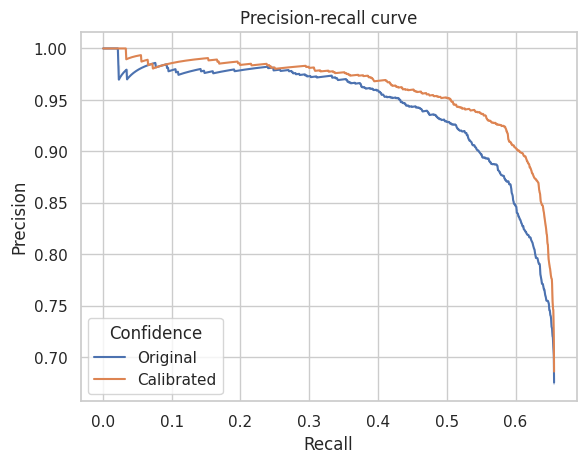

In [16]:
# -- Plot precision-recall curve


def compute_precision_recall_curve(
    dataset: pd.DataFrame,
    confidence_column: str,
    label_column: str,
    name: str,
) -> pd.DataFrame:
    original = dataset[[confidence_column, label_column]]
    original = original.sort_values(by=confidence_column, ascending=False)
    cum_correct = np.cumsum(original[label_column])
    precision = cum_correct / np.arange(1, len(original) + 1)
    recall = cum_correct / len(original)
    metrics = pd.DataFrame({"precision": precision, "recall": recall}).reset_index(
        drop=True
    )
    metrics["name"] = name
    return metrics


original = compute_precision_recall_curve(
    dataset=test_dataset.metadata,
    confidence_column="confidence",
    label_column="correct",
    name="Original",
)
calibrated = compute_precision_recall_curve(
    dataset=test_dataset.metadata,
    confidence_column="calibrated_confidence",
    label_column="correct",
    name="Calibrated",
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics["fdr"] = 1 - metrics["precision"]

ax = sns.lineplot(data=metrics, x="recall", y="precision", hue="name")
ax.set(xlabel="Recall", ylabel="Precision", title="Precision-recall curve")
ax.legend(title="Confidence")
plt.show()

### B. Confidence score transformation

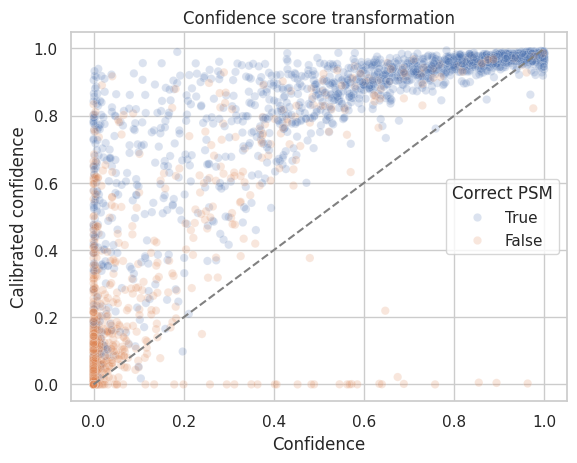

In [17]:
# -- Plot confidence score transformation
data = test_dataset.metadata[["confidence", "calibrated_confidence", "correct"]].copy(
    deep=True
)
data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
data["correct"] = (
    data["correct"]
    .map({True: "True", False: "False"})
    .astype(pd.CategoricalDtype(categories=["True", "False"], ordered=True))
)

ax = sns.scatterplot(
    data=data,
    x="confidence",
    y="calibrated_confidence",
    hue="correct",
    alpha=0.2,
    legend=True,
)
ax.plot([0.0, 1.0], [0.0, 1.0], color="grey", linestyle="--")
ax.set(
    xlabel="Confidence",
    ylabel="Calibrated confidence",
    title="Confidence score transformation",
)

legend = ax.get_legend()
if legend is not None:
    legend.set_title("Correct PSM")

plt.show()

### C. Confidence distributions

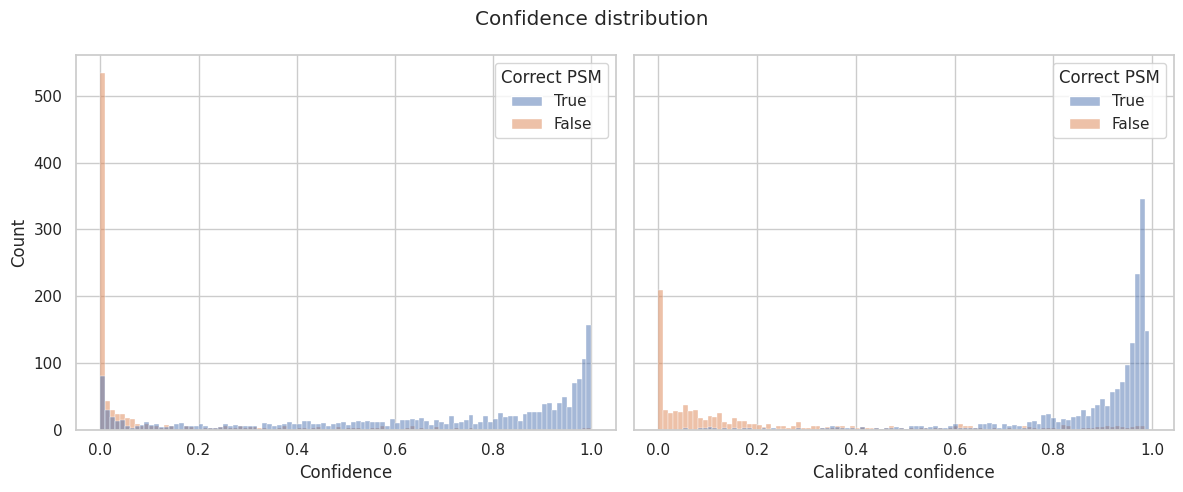

In [18]:
# -- Plot confidence distribution
data = test_dataset.metadata[["confidence", "calibrated_confidence", "correct"]].copy(
    deep=True
)
data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
data["correct"] = (
    data["correct"]
    .map({True: "True", False: "False"})
    .astype(pd.CategoricalDtype(categories=["True", "False"], ordered=True))
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Raw confidence distribution
ax0 = sns.histplot(
    data=data,
    x="confidence",
    hue="correct",
    hue_order=["True", "False"],
    bins=100,
    multiple="layer",
    alpha=0.5,
    legend=True,
    ax=axes[0],
)
axes[0].set(xlabel="Confidence", ylabel="Count")
sns.move_legend(axes[0], "best", title="Correct PSM")

# Calibrated confidence distribution
ax1 = sns.histplot(
    data=data,
    x="calibrated_confidence",
    hue="correct",
    hue_order=["True", "False"],
    bins=100,
    multiple="layer",
    alpha=0.5,
    legend=True,
    ax=axes[1],
)
axes[1].set(xlabel="Calibrated confidence", ylabel="Count")
sns.move_legend(axes[1], "best", title="Correct PSM")

fig.suptitle("Confidence distribution")
plt.tight_layout()

plt.show()

### D. Calibration curves

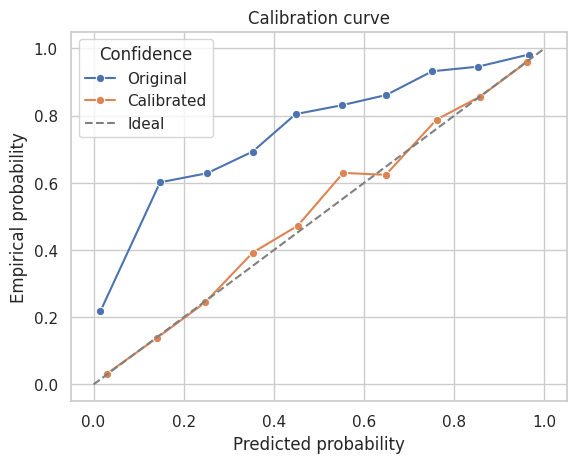

In [19]:
# Plot calibration curve


def compute_calibration_curve(
    df: pd.DataFrame, pred_col: str, label_col: str, name: str, n_bins: int = 20
) -> pd.DataFrame:
    data = df[[pred_col, label_col]].dropna().copy(deep=True)
    data[pred_col] = data[pred_col].clip(0.0, 1.0)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_cats = pd.cut(data[pred_col], bins=bins, include_lowest=True)
    bin_cats.name = "bin"
    grouped = (
        data.groupby(bin_cats, observed=True)
        .agg(
            pred_mean=(pred_col, "mean"),
            empirical=(label_col, "mean"),
            count=(label_col, "size"),
        )
        .reset_index()
    )
    grouped = grouped[grouped["count"] > 0]
    grouped["bin_center"] = grouped["bin"].apply(lambda iv: (iv.left + iv.right) / 2)
    grouped["name"] = name
    return grouped[["pred_mean", "empirical", "count", "bin_center", "name"]]


metrics_orig = compute_calibration_curve(
    test_dataset.metadata, "confidence", "correct", name="Original", n_bins=10
)
metrics_cal = compute_calibration_curve(
    test_dataset.metadata,
    "calibrated_confidence",
    "correct",
    name="Calibrated",
    n_bins=10,
)
metrics = pd.concat([metrics_orig, metrics_cal], ignore_index=True)

ax = sns.lineplot(data=metrics, x="pred_mean", y="empirical", hue="name", marker="o")
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle="--", color="gray", label="Ideal")
ax.set(
    xlabel="Predicted probability",
    ylabel="Empirical probability",
    title="Calibration curve",
)
ax.legend(title="Confidence")
plt.show()


## 7. FDR control: two approaches

1. **Database-grounded FDR**
  - Use when you have ground-truth peptide labels for this dataset (good for evaluation/benchmarking).
  - Outputs: a confidence cutoff at a target FDR; optional per-PSM FDR via `add_psm_fdr` and q-values via `add_psm_q_value`.
  - Extrapolates poorly to real *de novo* workflows

2. **Non-parametric (label-free) FDR**
  - Use on unlabelled datasets; uses calibrated confidence to directly estimate FDR (that is, the probability that a PSM is incorrect given its calibrated score is greater than or equal to a specified confidence score cutoff).
  - No ground truth labels required
  - Outputs: a confidence cutoff at a target FDR; per-PSM metrics: FDR (`psm_fdr`), q-value (`psm_q_value`), and posterior error probability (`psm_pep`).

**Note**: Fit on the column you intend to use downstream (e.g., `calibrated_confidence`).

### PSM-specific FDR metrics

**Q-values and FDR**

FDR for a PSM is the probability of that PSM being incorrect given that its confidence score is greater than or equal to a given cutoff $s$.  It is formally defined as: $P(\text{incorrect} | S \ge s)$. A q-value is the minimum FDR threshold at which a given PSM would be considered significant. More precisely, it's the smallest FDR cutoff that would still include this PSM in the filtered results.

**Posterior error probability (PEP)**

The PEP is the estimated probability that a given PSM is incorrect, given its observed features and confidence score. It is formally defined as: $P(\text{incorrect} | \text{observed features}, s)$. This metrics only considers the PSM at hand, whereas both PSM-specific FDR values and q-values can vary based on the surrounding PSMs in the analysis.

**Example scenario**

A PSM with confidence 0.85 might have a PSM-specific FDR of 0.02, a q-value of 0.015 and a PEP of 0.04.
- The PSM-specific FDR tells you: "If I filter to confidence ≥ 0.85, I expect 2% of those PSMs to be wrong"
- The q-value tells you: "This PSM would be significant even at a 1.5% FDR threshold"
- The PEP tells you: "This specific PSM has a 4% chance of being wrong."

In [20]:
# -- Database-grounded FDR control
database_grounded_fdr_control = DatabaseGroundedFDRControl(
    confidence_feature="calibrated_confidence"
)
database_grounded_fdr_control.fit(
    dataset=test_dataset.metadata, residue_masses=RESIDUE_MASSES
)
print(
    "Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence:",
    database_grounded_fdr_control.get_confidence_cutoff(threshold=0.05),
)

Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.8304821004570054


In [21]:
# -- Non-parametric FDR control (Winnow-specific)
non_parametric_fdr_control = NonParametricFDRControl()
non_parametric_fdr_control.fit(dataset=test_dataset.metadata["calibrated_confidence"])
print(
    "Non-parametric FDR control confidence cutoff at 5% FDR using calibrated confidence:",
    non_parametric_fdr_control.get_confidence_cutoff(threshold=0.05),
)

Non-parametric FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.8422312806888002


In [22]:
# -- Add PSM-specific FDR metrics to the dataset
# Non-parametric FDR control
test_dataset_winnow_metrics = non_parametric_fdr_control.add_psm_fdr(
    test_dataset.metadata, confidence_col="calibrated_confidence"
)
test_dataset_winnow_metrics = non_parametric_fdr_control.add_psm_q_value(
    test_dataset_winnow_metrics, confidence_col="calibrated_confidence"
)
test_dataset_winnow_metrics = non_parametric_fdr_control.add_psm_pep(
    test_dataset_winnow_metrics, confidence_col="calibrated_confidence"
)

# Database-grounded FDR control
test_dataset_dbg_metrics = database_grounded_fdr_control.add_psm_fdr(
    test_dataset.metadata, confidence_col="calibrated_confidence"
)
test_dataset_dbg_metrics = database_grounded_fdr_control.add_psm_q_value(
    test_dataset_dbg_metrics, confidence_col="calibrated_confidence"
)

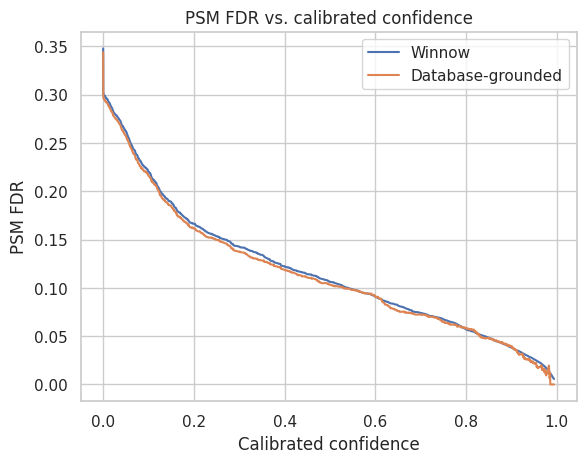

In [23]:
metrics = test_dataset_winnow_metrics[["calibrated_confidence", "psm_fdr"]].copy(
    deep=True
)
ax = sns.lineplot(
    x=np.asarray(test_dataset_winnow_metrics["calibrated_confidence"], dtype=float),
    y=np.asarray(test_dataset_winnow_metrics["psm_fdr"], dtype=float),
    errorbar=None,
    label="Winnow",
)
ax = sns.lineplot(
    x=np.asarray(test_dataset_dbg_metrics["calibrated_confidence"], dtype=float),
    y=np.asarray(test_dataset_dbg_metrics["psm_fdr"], dtype=float),
    errorbar=None,
    label="Database-grounded",
)
ax.set_xlabel("Calibrated confidence")
ax.set_ylabel("PSM FDR")
ax.set_title("PSM FDR vs. calibrated confidence")
ax.grid(True)
plt.show()

## 8. Applying to new data

This section simulates how you'd use winnow in a real *de novo* sequencing pipeline, when PSMs from other engines are not available.

In [24]:
# -- Load the raw, unlabelled data
logger.info("Loading raw dataset.")
dataset = InstaNovoDatasetLoader().load(
    data_path="winnow-ms-datasets/helaqc_raw_less_train.parquet",
    predictions_path="winnow-ms-datasets/helaqc_raw_less_train_beams.csv",
)

logger.info("Filtering dataset.")
raw_filtered_dataset = (
    dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
    .filter_entries(
        metadata_predicate=lambda row: row["precursor_charge"] > 6
    )  # Prosit-specific filtering
    .filter_entries(
        metadata_predicate=lambda row: len(row["prediction"]) > 30
    )  # Prosit-specific filtering
    .filter_entries(
        predictions_predicate=lambda row: len(row[1].sequence) > 30
    )  # Prosit-specific filtering
)

print("Number of PSMs in the unlabelled dataset:", len(raw_filtered_dataset))

Loading raw dataset.


[09/30/25 17:58:53] INFO     Loading raw dataset.                                                                                                               ]8;id=860276;file:///tmp/ipykernel_19645/2207885550.py\2207885550.py]8;;\:]8;id=132997;file:///tmp/ipykernel_19645/2207885550.py#2\2]8;;\

Applying dataset filters...


Filtering dataset.


[09/30/25 17:59:03] INFO     Filtering dataset.                                                                                                                 ]8;id=429128;file:///tmp/ipykernel_19645/2207885550.py\2207885550.py]8;;\:]8;id=995943;file:///tmp/ipykernel_19645/2207885550.py#8\8]8;;\

Number of PSMs in the unlabelled dataset: 21370


In [25]:
# -- Predict on the raw, unlabelled data
calibrator.predict(raw_filtered_dataset)

Prosit_2020_intensity_HCD:: 100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


In [26]:
# -- Non-parametric FDR control (Winnow-specific)
non_parametric_fdr_control = NonParametricFDRControl()
non_parametric_fdr_control.fit(
    dataset=raw_filtered_dataset.metadata["calibrated_confidence"]
)
confidence_cutoff = non_parametric_fdr_control.get_confidence_cutoff(threshold=0.05)
print(
    f"Non-parametric FDR control confidence cutoff at 5% FDR using calibrated confidence: {confidence_cutoff}"
)

Non-parametric FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.9173491600627199


In [27]:
# -- Add PSM-specific FDR metrics to the dataset
raw_filtered_dataset_metadata = non_parametric_fdr_control.add_psm_fdr(
    raw_filtered_dataset.metadata, confidence_col="calibrated_confidence"
)
raw_filtered_dataset_metadata = non_parametric_fdr_control.add_psm_q_value(
    raw_filtered_dataset_metadata, confidence_col="calibrated_confidence"
)
raw_filtered_dataset_metadata = non_parametric_fdr_control.add_psm_pep(
    raw_filtered_dataset_metadata, confidence_col="calibrated_confidence"
)

In [28]:
# -- Filter dataset to only include PSMs with calibrated confidence above the cutoff
filtered_dataset = raw_filtered_dataset.filter_entries(
    metadata_predicate=lambda row: row["calibrated_confidence"] <= confidence_cutoff
)

print(f"Number of PSMs in dataset at 5% FDR: {len(filtered_dataset)}")

Number of PSMs in dataset at 5% FDR: 785


## 9. Adding custom features

How to implement your own calibration features:

In [29]:
class CustomFeature(CalibrationFeatures):
    @property
    def name(self) -> str:
        return "My Custom Feature"

    def compute(self, dataset: CalibrationDataset) -> None:
        # Your feature computation logic
        pass

## 10. Saving and reusing a calibrator

If you plan to apply the same feature configuration to external data, you can save and reload the calibrator.

In [30]:
# -- Save
out_dir = Path("outputs/helaqc_calibrator")
ProbabilityCalibrator.save(calibrator, out_dir)

# -- Load
loaded = ProbabilityCalibrator.load(out_dir)
print("Loaded features:", loaded.features)

Loaded features: ['Mass Error', 'Prosit Features', 'Prosit iRT Features', 'Chimeric Features', 'Beam Features']


## 11. CLI usage

You can run the same workflow headlessly via the CLI.

```bash
# Train a calibrator
winnow train \
  --data-source instanovo \
  --dataset-config-path configs/helaqc_labelled.yaml \
  --model-output-folder outputs/helaqc_calibrator \
  --dataset-output-path outputs/helaqc_train_outputs.csv

# Predict + FDR on new data
winnow predict \
  --data-source instanovo \
  --dataset-config-path configs/helaqc_raw.yaml \
  --model-folder outputs/helaqc_calibrator \
  --method winnow \
  --fdr-threshold 0.05 \
  --confidence-column calibrated_confidence \
  --output-path outputs/helaqc_filtered.csv
```

## 12. Using Winnow without Prosit (offline/minimal)

If you don't have Prosit access, have data with many diverse modifications, or want a minimal setup, you can disable Prosit-dependent features and still benefit from calibration using features available locally.

In [31]:
# Minimal feature set: no Prosit dependency
cal_min = ProbabilityCalibrator(SEED)
cal_min.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
cal_min.add_feature(BeamFeatures())

cal_min.fit(train_dataset)
cal_min.predict(test_dataset)
print("Finished training minimal calibrator. Columns:", cal_min.columns)

Finished training minimal calibrator. Columns: ['Mass Error', 'margin', 'median_margin', 'entropy', 'z-score']


## 13. Pretrained general calibrator

We have published a pretrained calibrator for InstaNovo predictions that uses the default feature set (Mass Error, Prosit spectral, Prosit iRT, Chimeric, Beam) on Hugging Face. You can load it and apply it to your own datasets without retraining!

**Notes**:
- Prosit-dependent features are still computed at inference, so Prosit access is required.
- Ensure your modification tokens and input columns match this tutorial's format.

In [32]:
# -- Download the general model
calib_repo = "InstaDeepAI/winnow-general-model"
calib_dir = Path("./winnow-general-model")

In [33]:
snapshot_download(repo_id=calib_repo, repo_type="model", local_dir=calib_dir)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 1815.40it/s]


'/home/j-vangoey/code/winnow/examples/winnow-general-model'

In [34]:
# -- Load the general model
general_model = ProbabilityCalibrator.load(calib_dir)
print("Loaded pretrained features:", general_model.features)

Loaded pretrained features: ['Mass Error', 'Prosit Features', 'Prosit iRT Features', 'Chimeric Features', 'Beam Features']


Let's replicate results in our paper on the C. elegans dataset

In [35]:
# -- Download the C. elegans dataset
snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    allow_patterns=["celegans_labelled*.parquet", "celegans_labelled*.csv"],
    local_dir=save_dir,
)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 1702.92it/s]


'/home/j-vangoey/code/winnow/examples/winnow-ms-datasets'

In [36]:
# -- Load data
logger.info("Loading dataset.")
celegans_dataset = InstaNovoDatasetLoader().load(
    data_path="winnow-ms-datasets/celegans_labelled.parquet",
    predictions_path="winnow-ms-datasets/celegans_labelled_beams.csv",
)

logger.info("Filtering dataset.")
celegans_filtered_dataset = (
    celegans_dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
    .filter_entries(
        metadata_predicate=lambda row: row["precursor_charge"] > 6
    )  # Prosit-specific filtering, see https://github.com/Nesvilab/FragPipe/issues/1775
    .filter_entries(
        metadata_predicate=lambda row: len(row["prediction"]) > 30
    )  # Prosit-specific filtering
    .filter_entries(
        predictions_predicate=lambda row: len(row[1].sequence) > 30
    )  # Prosit-specific filtering
)

Loading dataset.


[09/30/25 17:59:50] INFO     Loading dataset.                                                                                                                    ]8;id=32381;file:///tmp/ipykernel_19645/728313241.py\728313241.py]8;;\:]8;id=415987;file:///tmp/ipykernel_19645/728313241.py#2\2]8;;\

Applying dataset filters...


Filtering dataset.


[09/30/25 18:01:17] INFO     Filtering dataset.                                                                                                                  ]8;id=919900;file:///tmp/ipykernel_19645/728313241.py\728313241.py]8;;\:]8;id=376227;file:///tmp/ipykernel_19645/728313241.py#8\8]8;;\

In [37]:
# -- Predict
general_model.predict(celegans_filtered_dataset)

Prosit_2020_intensity_HCD:: 100%|██████████| 213/213 [01:04<00:00,  3.32it/s]


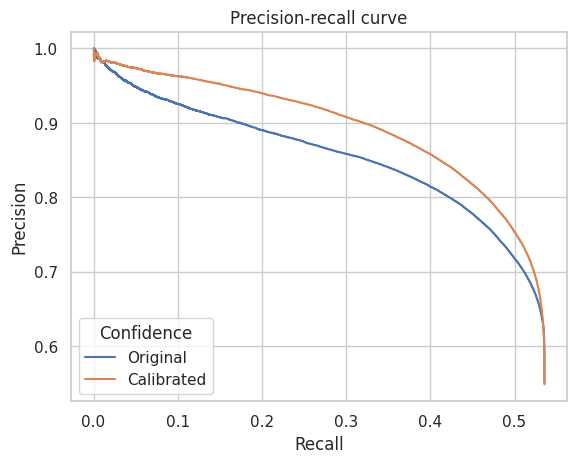

In [38]:
original = compute_precision_recall_curve(
    dataset=celegans_filtered_dataset.metadata,
    confidence_column="confidence",
    label_column="correct",
    name="Original",
)
calibrated = compute_precision_recall_curve(
    dataset=celegans_filtered_dataset.metadata,
    confidence_column="calibrated_confidence",
    label_column="correct",
    name="Calibrated",
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics["fdr"] = 1 - metrics["precision"]

ax = sns.lineplot(data=metrics, x="recall", y="precision", hue="name")
ax.set(xlabel="Recall", ylabel="Precision", title="Precision-recall curve")
ax.legend(title="Confidence", loc="lower left")
plt.show()

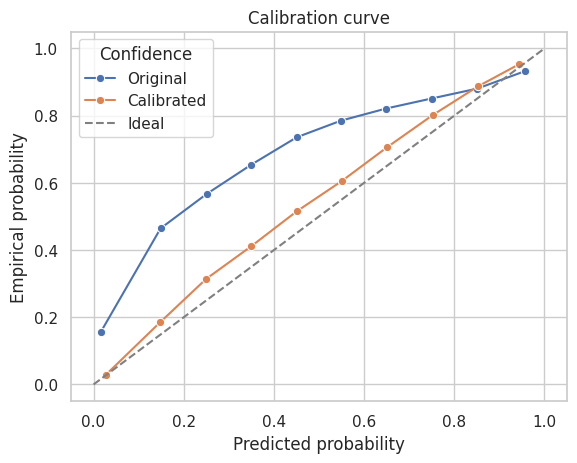

In [39]:
metrics_orig = compute_calibration_curve(
    celegans_filtered_dataset.metadata,
    "confidence",
    "correct",
    name="Original",
    n_bins=10,
)
metrics_cal = compute_calibration_curve(
    celegans_filtered_dataset.metadata,
    "calibrated_confidence",
    "correct",
    name="Calibrated",
    n_bins=10,
)
metrics = pd.concat([metrics_orig, metrics_cal], ignore_index=True)

ax = sns.lineplot(data=metrics, x="pred_mean", y="empirical", hue="name", marker="o")
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle="--", color="gray", label="Ideal")
ax.set(
    xlabel="Predicted probability",
    ylabel="Empirical probability",
    title="Calibration curve",
)
ax.legend(title="Confidence")
plt.show()

In [40]:
# -- Compute FDR
# Non-parametric FDR control
non_parametric_fdr_control = NonParametricFDRControl()
non_parametric_fdr_control.fit(
    dataset=celegans_filtered_dataset.metadata["calibrated_confidence"]
)
confidence_cutoff = non_parametric_fdr_control.get_confidence_cutoff(threshold=0.05)
print(
    f"Non-parametric FDR control confidence cutoff at 5% FDR using calibrated confidence: {confidence_cutoff}"
)

# Database-grounded FDR control
database_grounded_fdr_control = DatabaseGroundedFDRControl(
    confidence_feature="calibrated_confidence"
)
database_grounded_fdr_control.fit(
    dataset=celegans_filtered_dataset.metadata, residue_masses=RESIDUE_MASSES
)
confidence_cutoff_dbg = database_grounded_fdr_control.get_confidence_cutoff(
    threshold=0.05
)
print(
    f"Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence: {confidence_cutoff_dbg}"
)

# -- Calculate PSM-specific FDR metrics
celegans_winnow_psm_fdr = non_parametric_fdr_control.add_psm_fdr(
    celegans_filtered_dataset.metadata, confidence_col="calibrated_confidence"
)[["spectrum_id", "calibrated_confidence", "psm_fdr"]]

celegans_dbg_psm_fdr = database_grounded_fdr_control.add_psm_fdr(
    celegans_filtered_dataset.metadata, confidence_col="calibrated_confidence"
)[["spectrum_id", "calibrated_confidence", "psm_fdr"]]

Non-parametric FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.9134040294699176
Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.8904919079234012


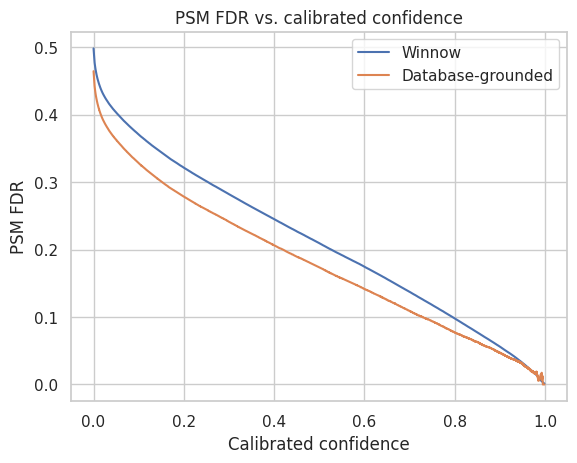

In [41]:
metrics = celegans_winnow_psm_fdr[["calibrated_confidence", "psm_fdr"]].copy(deep=True)
ax = sns.lineplot(
    x=np.asarray(celegans_winnow_psm_fdr["calibrated_confidence"], dtype=float),
    y=np.asarray(celegans_winnow_psm_fdr["psm_fdr"], dtype=float),
    errorbar=None,
    label="Winnow",
)
ax = sns.lineplot(
    x=np.asarray(celegans_dbg_psm_fdr["calibrated_confidence"], dtype=float),
    y=np.asarray(celegans_dbg_psm_fdr["psm_fdr"], dtype=float),
    errorbar=None,
    label="Database-grounded",
)
ax.set_xlabel("Calibrated confidence")
ax.set_ylabel("PSM FDR")
ax.set_title("PSM FDR vs. calibrated confidence")
ax.grid(True)
plt.show()

## Tips and troubleshooting
- Ensure your spectrum data and beam predictions share a common, unique `spectrum_id` for merging.
- Prosit-dependent features filter unsupported modifications; if you see many rows removed, review modification tokens.
- If beam results often contain fewer than 2-3 candidates, chimeric/beam features may carry limited information (warnings will appear).
- Always validate on a labelled subset or via consistency checks before deploying to new datasets.

## Resources
- 📚 GitHub: https://github.com/instadeepai/winnow
- 🔧 CLI: `winnow --help`